In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
movie_metadata = pd.read_csv("movie.metadata.tsv", sep='\t', lineterminator='\n', header=None)
movie_metadata = movie_metadata.rename(columns={0: 'wikipedia_movie_id', 2: 'movie_title', 3:"release_date", 4:"box_office_revenue"})
movie_metadata.head()

,wikipedia_movie_id,1,movie_title,release_date,box_office_revenue,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [116]:
# we shouldn't consider movies with no revenue data, no valid date or no valid rating

In [117]:
#we are interested in those that have box office revenue data and a valid date
print("Num movies before filtering: ",movie_metadata.shape[0]) # 81741
movie_metadata = movie_metadata[movie_metadata["box_office_revenue"].notna()]

movie_metadata = movie_metadata[movie_metadata["release_date"].notna()]

print("Num movies after filtering for valid revenue and date data: ", movie_metadata.shape[0])

Num movies before filtering:  81741
Num movies after filtering for valid revenue and date data:  8328


### A lot of the movies have empty Box Office Revenue so we acquire that data through other needs
We scrape the IMDB website

In [118]:
### TODO Insert scraping stuff or maybe just the new movie_metadata

### We preprocess the metadata

Text(0.5, 1.0, 'Number of Movies Released a Certain Year')

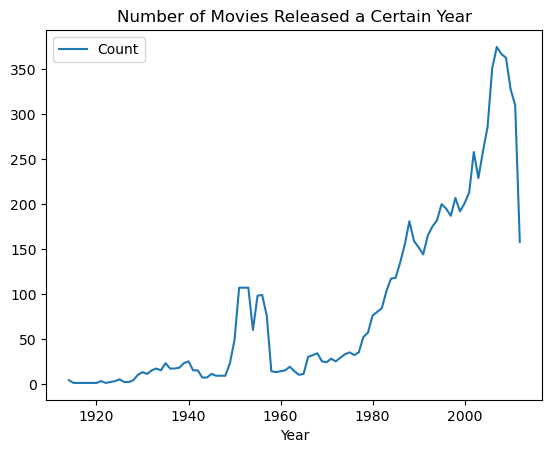

In [119]:
# Convert the 'release_date' column to datetime
movie_metadata['release_date'] = pd.to_datetime(movie_metadata['release_date'], errors='coerce')

# Extract the year from the dates
movie_metadata['Year'] = movie_metadata['release_date'].dt.year

# We need to remove the 1897 outlier as we have no inflation data for before 1913
movie_metadata = movie_metadata[movie_metadata["Year"] >= 1913]

# Group by year and count occurrences
yearly_counts = movie_metadata['Year'].value_counts().reset_index()
yearly_counts.columns = ['Year', 'Count']

yearly_counts.sort_values(by='Year', inplace = True)
yearly_counts.plot(x = "Year", y = "Count")
plt.title("Number of Movies Released a Certain Year")

### We can see that there is little data for certain years. Maybe we should only consider what came after 1950s.

### It doesn't make sense to compare box office revenue of movies that were created at different times
### As such we are more interested in the revenue that has been adjusted for inflation.

In [120]:
# inflation data from:
# https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/
us_inflation = pd.read_csv("US_yearly_inflation.csv")
us_yearly_inflation = us_inflation[["Year", "Avg-Avg"]].fillna(0)
us_yearly_inflation

,Year,Avg-Avg
0,1913,0.0
1,1914,1.0
2,1915,1.0
3,1916,7.9
4,1917,17.4
...,...,...
105,2018,2.4
106,2019,1.8
107,2020,1.2
108,2021,4.7


Text(0.5, 1.0, 'Yearly USD Inflation Rates (From Average to Average)')

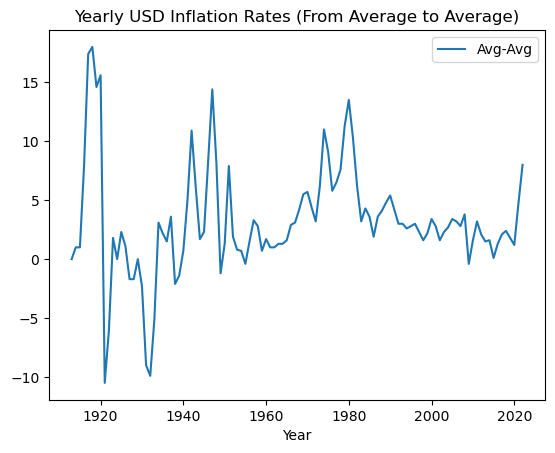

In [121]:
us_yearly_inflation.plot(x="Year", y="Avg-Avg")
plt.title("Yearly USD Inflation Rates (From Average to Average)")

In [122]:
prices = [1] # we set the initial price as a reference

# Calculate prices based on inflation rates
for index, row in us_yearly_inflation.iterrows():
    if index == 0:
        continue # Skip the first row (no inflation data for the initial price)
    price = prices[-1] * (1 + row['Avg-Avg'] / 100)
    prices.append(price)

# Add the prices to the DataFrame
us_yearly_inflation['Price'] = prices

Text(0.5, 1.0, 'Price in USD Adjusted for Inflation')

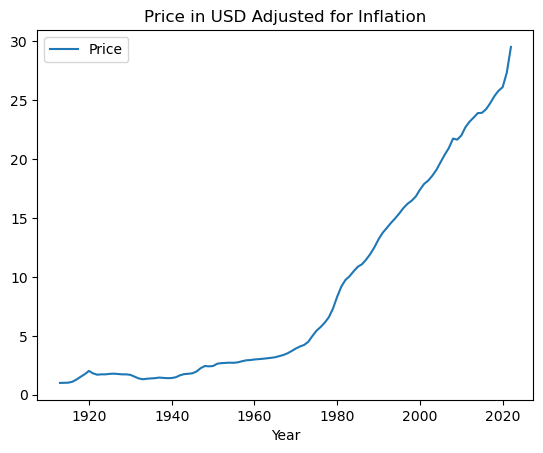

In [123]:
us_yearly_inflation.plot(x = "Year", y = "Price")
plt.title("Price in USD Adjusted for Inflation")

### Now Lets plot the box office revenue
We can plot the max box office revenue for that year. Note that we are interested in the best movies so we don't plot average or median.

Text(0.5, 1.0, 'Max Box Office Revenue per Year')

<Figure size 1000x600 with 0 Axes>

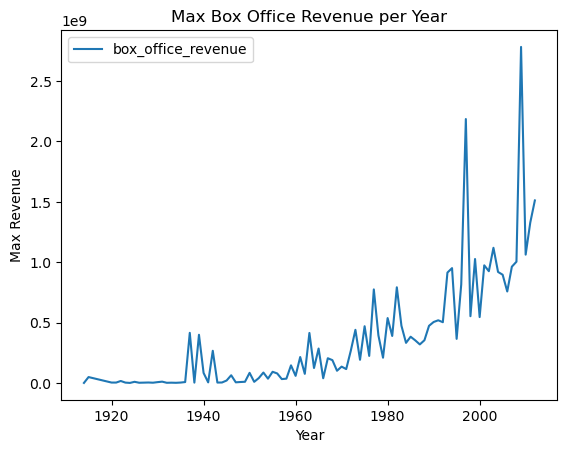

In [124]:
# Calculate the max box office revenue for each year
max_revenue_per_year = movie_metadata.groupby('Year')['box_office_revenue'].max().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))
max_revenue_per_year.plot(x = "Year", y = "box_office_revenue")
plt.xlabel('Year')
plt.ylabel('Max Revenue')
plt.title('Max Box Office Revenue per Year')

max_revenue_indices = movie_metadata.groupby('year')['box_office_revenue'].idxmax()

movies_max_revenue = movie_metadata.loc[max_revenue_indices].sort_values(by='year')
movies_max_revenue.head() #interesting to figure out what spikes correspond to

Looking at the previous graph it seems like Avatar is the best movie! But when adjusted for inflation, Gone In The Wild a 1939 movie is very impressive!!!

### We need to adjust movie revenues to inflation to make them comparable

In [125]:
def adjust_revenue_for_inflation(revenue_df, inflation_df, base_year=2012): # our data contains up to year 2012
    # Create a dictionary to map year and corresponding price
    price_dict = dict(zip(inflation_df['Year'], inflation_df['Price']))
    
    # the first year in inflation_df the price is set at 1 then for every year we have the new price adjusted for inflation
    price_base_year = price_dict[base_year] 
    
    #box_office_rev * price_base_year / price_release_year

    # Create a new column in the revenue DataFrame to store adjusted revenues
    revenue_df['AdjustedRevenue'] = (revenue_df['box_office_revenue'] * price_base_year / revenue_df['Year'].apply(lambda year: price_dict[year])).copy()#revenue_df.apply(lambda row: row['box_office_revenue'].copy() * price_base_year / price_dict[row['Year']], axis=1)

    return revenue_df

In [126]:
# We need to remove the 1897 outlier as we have no inflation data for before 1913
max_revenue_per_year = max_revenue_per_year[max_revenue_per_year["Year"] >= 1913]

# Adjust the revenue for inflation
adjusted_max_revenue = adjust_revenue_for_inflation(max_revenue_per_year, us_yearly_inflation)
adjusted_max_revenue

,Year,box_office_revenue,AdjustedRevenue
0,1914.0,1.500000e+06,3.442319e+07
1,1915.0,5.000000e+07,1.136079e+09
2,1920.0,4.500000e+06,5.163415e+07
3,1921.0,4.500000e+06,5.769179e+07
4,1922.0,1.753097e+07,2.393547e+08
...,...,...,...
90,2008.0,1.004558e+09,1.071109e+09
91,2009.0,2.782275e+09,2.978511e+09
92,2010.0,1.063172e+09,1.120234e+09
93,2011.0,1.328111e+09,1.356002e+09


Text(0.5, 1.0, 'Max Box Office Revenue per Year, adjusted for inflation relative to 2012')

<Figure size 1000x600 with 0 Axes>

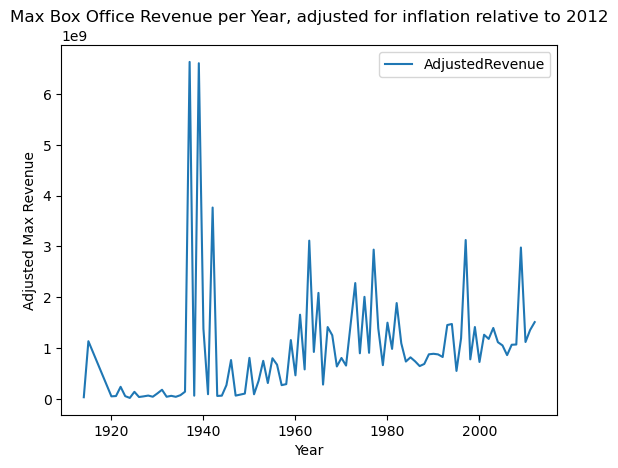

In [127]:
# Create a line plot
plt.figure(figsize=(10, 6))
adjusted_max_revenue.plot(x = "Year", y = "AdjustedRevenue")
plt.xlabel('Year')
plt.ylabel('Adjusted Max Revenue')
plt.title('Max Box Office Revenue per Year, adjusted for inflation relative to 2012')

### Trying to fill empty values (Not necessary if the scraping works well enough)

our_data = pd.read_csv("movie.metadata.tsv", sep='\t', lineterminator='\n', header=None)
our_data = our_data.rename(columns={0: 'wikipedia_movie_id', 2: 'movie_title', 3:"release_date", 4:"box_office_revenue"})
our_data['year'] = pd.to_datetime(our_data['release_date'], errors='coerce').dt.year

movies_without_revenue = our_data[our_data["box_office_revenue"].isna()][["movie_title", "wikipedia_movie_id", "year", "release_date"]]

kaggle_data = pd.read_csv("kaggle_movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
kaggle_data["year"] = pd.to_datetime(kaggle_data['release_date'], errors='coerce').dt.year
kaggle_data = kaggle_data[kaggle_data["revenue"] > 0]
kaggle_data.head(1)

movies_without_revenue.merge(kaggle_data, left_on=['movie_title', "year"], right_on=['title', "year"], how='inner')

In [128]:
df_data = adjust_revenue_for_inflation(movie_metadata, us_yearly_inflation)

### Now that we have the adjusted Revenue we can create our score system that considers revenue and rating

The score is composed of two components:

Box Office Revenue Component (BORC) and Rating Component (RC):

#### BORC = [log(Adjusted Movie Revenue) - log(MinAdjustedMovieRevenue)] / [log(MaxAdjustedMovieRevenue) - log(MinAdjustedMovieRevenue)]


#### RC = [Movie Rating - MinMovieRating] / [MaxMovieRating - MinMovieRating]

Note that the BORC and RC are between 0 and 1

We want a score that is over 100 thus we multiply by 50
### Movie Score = (BORC + RC) * 50


In [133]:
# Calculate the components
min_adj_movie_revenue = df_data['AdjustedRevenue'].min()
max_adj_movie_revenue = df_data['AdjustedRevenue'].max()
#min_movie_rating = df_data['Movie Rating'].min()
#max_movie_rating = df_data['Movie Rating'].max()

df_data['BORC'] = (np.log(df_data['AdjustedRevenue']) - np.log(min_adj_movie_revenue)) / (np.log(max_adj_movie_revenue) - np.log(min_adj_movie_revenue))
df_data["RC"] = 0
#df_data['RC'] = (df_data['Movie Rating'] - min_movie_rating) / (max_movie_rating - min_movie_rating)

# Calculate Movie Score
df_data['Movie Score'] = (df_data['BORC'] + df_data['RC']) * 50

In [134]:
df_data

,wikipedia_movie_id,1,movie_title,release_date,box_office_revenue,5,6,7,8,Year,AdjustedRevenue,BORC,RC,Movie Score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,1.815737e+07,0.558118,0,27.905899
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,5.858842e+07,0.645855,0,32.292750
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,1.882019e+07,0.560803,0,28.040163
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964.0,7.574725e+08,0.837546,0,41.877302
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999.0,2.964593e+04,0.077476,0,3.873810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81695,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",1988.0,5.604929e+08,0.814990,0,40.749487
81720,7761830,/m/0kvgqb,Spaced Invaders,1990-01-01,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",1990.0,2.700875e+07,0.587858,0,29.392889
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",2000.0,9.251694e+06,0.507618,0,25.380913
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1993.0,3.638100e+07,0.610168,0,30.508403


### Now that we have the movie scores we can keep the top N percent and consider these as the Good films that we want to study

In [142]:
N = 0.25
num_movies = df_data.shape[0]
df_data = df_data.sort_values("Movie Score", ascending = False)

df_good_movies = df_data[: np.round(num_movies * N).astype(int)].copy()
df_bad_movies = df_data[np.round(num_movies * N).astype(int) :].copy()

In [143]:
df_good_movies

,wikipedia_movie_id,1,movie_title,release_date,box_office_revenue,5,6,7,8,Year,AdjustedRevenue,BORC,RC,Movie Score
12100,76361,/m/0k4d7,Snow White and the Seven Dwarfs,1937-12-21,4.160000e+08,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02l7c8"": ""Romance Film"", ""/m/04t36"": ""Mus...",1937.0,6.628043e+09,1.000000,0,50.000000
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...",1939.0,6.602256e+09,0.999708,0,49.985402
1253,683122,/m/04j1zjw,Bambi,1942-08-08,2.674472e+08,69.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil...",1942.0,3.764610e+09,0.957634,0,47.881714
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...",1997.0,3.125883e+09,0.943709,0,47.185457
7117,210224,/m/01dvps,Love with the Proper Stranger,1963-12-25,4.150049e+08,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06lbpz"": ""Social problem film"", ""/m/01t_v...",1963.0,3.113649e+09,0.943415,0,47.170773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73164,63310,/m/0h0h0,Day of the Dead,1985-01-01,3.400000e+07,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/0jb4p32"": ""Zombie Fil...",1985.0,7.252842e+07,0.661841,0,33.092039
65890,4427791,/m/0c1srs,Regarding Henry,1991-07-10,4.300150e+07,107.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/04gm78f"": ""Medical...",1991.0,7.252014e+07,0.661832,0,33.091611
58841,1643035,/m/05k1rz,Valiant,2005-03-25,6.174689e+07,75.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil...",2005.0,7.250095e+07,0.661812,0,33.090620
50360,106344,/m/0qmd5,The Elephant Man,1980-10-03,2.601086e+07,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03g3w"": ""History"", ""/m/017fp"": ""Biography...",1980.0,7.247828e+07,0.661789,0,33.089449


In [144]:
df_bad_movies

,wikipedia_movie_id,1,movie_title,release_date,box_office_revenue,5,6,7,8,Year,AdjustedRevenue,BORC,RC,Movie Score
54310,1183043,/m/04f74c,Kagemusha,1980-05-01,26000000.0,180.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/02n4lw"":...",1980.0,7.244801e+07,0.661758,0,33.087884
15471,617063,/m/02x18l,Murder by Numbers,2002-04-19,56714147.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",2002.0,7.234136e+07,0.661647,0,33.082368
13250,2236976,/m/06y79v,August Rush,2007-10-06,65278569.0,114.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mxx"": ""Childhood Drama"", ""/m/03rzvv"":...",2007.0,7.224811e+07,0.661551,0,33.077538
24437,5349123,/m/0dgt4t,Underdog,2007-08-03,65270477.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",2007.0,7.223915e+07,0.661541,0,33.077073
54891,2353104,/m/075ztz,"The Karate Kid, Part III",1989-06-30,38956288.0,112.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/02h8pkk""...",1989.0,7.215408e+07,0.661453,0,33.072661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39513,26783359,/m/0crs_32,Peep World,2011-03-25,11238.0,79.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01t_vv"": ""Comedy-drama"", ""/m/01z4y"": ""Com...",2011.0,1.147400e+04,0.006382,0,0.319119
56050,20122638,/m/04yft1h,Frankie and Alice,2010-12-10,10670.0,101.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/017fp"": ""Biography"", ""/m/07s9rl0"": ""Drama""}",2010.0,1.124268e+04,0.004857,0,0.242852
53942,33895664,/m/07k983r,Logan,2010-01-01,10474.0,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0hqxf"": ""Family Film"", ""/m/07s9rl0"": ""Dra...",2010.0,1.103616e+04,0.003468,0,0.173424
51695,29085210,/m/0dll0nz,GhettoPhysics,2010-01-01,10200.0,NaN,{},{},"{""/m/0cshrf"": ""Political cinema"", ""/m/0jtdp"": ...",2010.0,1.074745e+04,0.001483,0,0.074156
